<a href="https://colab.research.google.com/github/Arden-Zhu/fashion_net2/blob/master/A_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 1

In [0]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF

# from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from IPython.display import display 
from typing import *




In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
my_drive_dir = "/content/gdrive/My Drive/Machine Learning"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Helper functions

In [0]:
def is_listy(x:Any)->bool: return isinstance(x, (tuple,list))
def is_tuple(x:Any)->bool: return isinstance(x, tuple)
def is_dict(x:Any)->bool: return isinstance(x, dict)


## prepare images

In [4]:
since = time.time()
data_source_dir = os.path.join(my_drive_dir, 'Datasets\DeepFashion\Category and Attribute Prediction Benchmark'.replace('\\', '/'))
tar_file = os.path.join(data_source_dir, 'picked.tar')
if not os.path.exists('data'):
  os.mkdir('data')
! tar xf "{tar_file}" -C data/
print('%.3f' % (time.time() - since))

10.061


In [5]:
csv_file = os.path.join(data_source_dir, 'picked.csv')
df = pd.read_csv(csv_file, index_col=0)
df = df.loc[:, ['file', 'category_name', 'category_id']]
df['file'] = df.apply(lambda m: m.file[4:], axis=1)
df.head()

,file,category_name,category_id
23063,Kimono-Sleeved_Paisley_Blouse/img_00000121.jpg,Blouse,3
30780,Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg,Blouse,3
13998,Crochet_Lace-Paneled_Blouse/img_00000035.jpg,Blouse,3
123023,New_York_City_Pocket_Tee/img_00000012.jpg,Tee,18
21889,Georgette_Tulip_Back_Blouse/img_00000029.jpg,Blouse,3


In [6]:
def pick(n_train, n_test, categories):
  df_pick = pd.DataFrame(columns=['file', 'label', 'type'])

  for cat in categories:
    indexes = df.loc[df.category_name == cat].index.values
    indexes = np.random.permutation(indexes)

    # trainset
    df_slice = df.loc[indexes[:n_train]].loc[:, ['file', 'category_name']]
    df_slice.columns = ['file', 'label']
    df_slice['type'] = 'train'

    df_pick = pd.concat([df_pick, df_slice])
    # testset
    df_slice = df.loc[indexes[n_train:n_train + n_test]].loc[:, ['file', 'category_name']]
    df_slice.columns = ['file', 'label']
    df_slice['type'] = 'test'
    df_pick = pd.concat([df_pick, df_slice])

  return df_pick

#############
df_pick = pick(2, 1, ['Tee', 'Blouse', 'Top'])
df_pick.head(10)


,file,label,type
51381,But_Not_Really_Muscle_Tee/img_00000014.jpg,Tee,train
93938,Bad_Influence_Tee/img_00000057.jpg,Tee,train
133184,Retro_Graphic_Tee/img_00000058.jpg,Tee,test
15754,Diamond_Print_Chiffon_Blouse/img_00000050.jpg,Blouse,train
7629,Buttoned_Pocket_Blouse/img_00000082.jpg,Blouse,train
31813,Ruffled_Rose_Blouse/img_00000078.jpg,Blouse,test
62333,Cap-Sleeved_Boxy_Top/img_00000008.jpg,Top,train
136294,Boxy_Embroidered_Top/img_00000025.jpg,Top,train
34490,Boxy_Polka_Dot_Top/img_00000023.jpg,Top,test


In [0]:
df_pick = pick(500, 200, ['Tee', 'Blouse', 'Top'])

## load data

Tee
(224, 224)


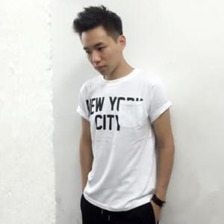

In [36]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

class ImageLabelDataset(Dataset):
  '''
  a dataset provides (image, label)
  '''
  def __init__(self, path:str, image_files, labels, transform=None, 
               normalize = imagenet_stats):
    self.path = path
    self.image_files = image_files
    self.labels = labels
    self.transform = transform
    if normalize:
      self.normalizer = transforms.Normalize(normalize[0], normalize[1])

    assert(len(image_files) == len(labels))

  def __len__(self):
    return len(self.labels)
  
  def get(self, idx):
    file = os.path.join(self.path, self.image_files[idx])
    
    #image = io.imread(file)
    #image = Image.fromarray(image)
    image = Image.open(file)
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return (image, label)

  def __getitem__(self, idx):
    image, label = self.get(idx)

    image = transforms.ToTensor()(image)

    if self.normalizer:
      image = self.normalizer(image)

    return (image, label)

##############################
image_ds = ImageLabelDataset('data/data/picked', ['New_York_City_Pocket_Tee/img_00000012.jpg'], ['Tee'], transform =  transforms.Resize(224))
assert(len(image_ds) == 1)

(image, label) = image_ds.get(0)
print(label)
assert(label == 'Tee')    

print(image.size)

display(image)

In [37]:
class DataSource():
  '''
  train_dl
  test_dl
  train_ds
  test_dl
  '''
  def __init__(self, path:str, df:pd.DataFrame, bs:int, transforms=None, 
               num_workers=0, normalize = imagenet_stats):
      '''
      path : path of images
      df : DataFrame with file, label, type
      '''
      # convert labels to number
      labels = np.sort(df['label'].unique())
      self.class_names = np.sort(df['label'].unique())
      self.class_indexes = {c:i for i, c in enumerate(self.class_names)}
      self.c = len(self.class_names)
      self.labels = [self.class_indexes[c] for c in labels]

      # transforms
      if not is_listy(transforms):
        train_tfm, test_tfm = transforms, transforms
      elif len(transforms) == 0:
        train_tfm, test_tfm = None, None
      elif len(transforms) == 1:
        train_tfm, test_tfm = transforms[0], transforms[0]
      else:
        train_tfm, test_tfm = transforms[0], transforms[1]

      # dataset
      is_train = df.type == 'train'
      self.train_ds = ImageLabelDataset(path, df[is_train]['file'].values, 
                                           [self.class_indexes[c] for c in df[is_train]['label'].values], 
                                           train_tfm, 
                                           normalize)
      self.test_ds = ImageLabelDataset(path, df[~is_train]['file'].values, 
                                          [self.class_indexes[c] for c in df[~is_train]['label'].values], 
                                          test_tfm,
                                          normalize
                                       )

      # dataloader
      self.train_dl = DataLoader(self.train_ds, batch_size=bs, shuffle=True, 
                                 num_workers=num_workers)
      
      self.test_dl = DataLoader(self.test_ds, batch_size=bs, shuffle=False, 
                                 num_workers=num_workers)

############################################################################
df2 = df.head(3).copy()
df2.columns=['file', 'type', 'label']
df2['type'] = ['train', 'test', 'train']
df2['label'] = ['a', 'b', 'c']
print(df2.head())

ds = DataSource('data/data/picked', df2, 1)
assert(len(ds.train_ds) == 2)
assert(len(ds.test_ds) == 1)
assert(ds.c == 3)
assert(ds.test_ds[0][1] == 1)
assert(ds.class_names[ds.test_ds[0][1]] == 'b')

for (image, label) in ds.test_dl:
  print(type(image))
  print(image.shape)
  print(label)
  print(image[0, 0, 0, :20])
  break

                                                 file   type label
23063  Kimono-Sleeved_Paisley_Blouse/img_00000121.jpg  train     a
30780     Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg   test     b
13998    Crochet_Lace-Paneled_Blouse/img_00000035.jpg  train     c
<class 'torch.Tensor'>
torch.Size([1, 3, 300, 207])
tensor([1])
tensor([2.1633, 2.1633, 2.1462, 2.1462, 2.1290, 2.1290, 2.1119, 2.1119, 2.1290,
        2.1290, 2.1290, 2.1119, 2.1119, 2.1119, 2.0948, 2.0948, 2.1119, 2.1119,
        2.1119, 2.1119])


## Transformation

In [0]:
def padToSquare(img, **kwargs):
    """Pad the input PIL Image to a square

    Args:
        img (PIL Image): Image to be resized.

    Returns:
        PIL Image: Padding image.
    """
    if not TF._is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
    
    w, h = img.size
    diff = w - h

    if diff == 0:
      return img
    else:
      if diff < 0:
        padding = (-diff // 2, 0, diff // 2 - diff, 0)
      else:
        padding = (0, diff // 2, 0, diff - diff//2)

      return TF.pad(img, padding, **kwargs)

In [0]:
class PadToSquare():
    """ Pad the input PIL Image to a square
    """
    def __init__(self, **kwargs):
      self.params = kwargs

    def __call__(self, x):
      return padToSquare(x, **self.params)


In [0]:
def tensor2img(tensor, stats):
  mean, std = stats
  img = tensor.numpy().transpose([1, 2, 0])
  img = img * std + mean
  img = np.minimum(img, 1)
  img = np.maximum(img, 0)
  return img


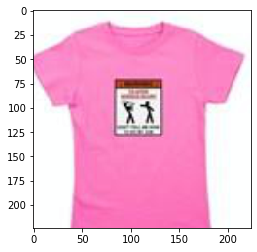

In [63]:
df_pick = pick(200, 50, ['Tee', 'Blouse', 'Top'])
tfms = [
  transforms.Compose([
    PadToSquare(padding_mode='reflect'),
    transforms.Resize(256),
    transforms.RandomCrop(224),
  ]),
  transforms.Compose([
    PadToSquare(padding_mode='reflect'),
    transforms.Resize(256),
    transforms.CenterCrop(224),
  ]),
]

ds = DataSource('data/data/picked', df_pick, 4, num_workers=4, transforms=tfms)

images, labels = next(iter(ds.train_dl))

images.shape

img = tensor2img(images[0], imagenet_stats)
plt.imshow(img)
plt.show()